 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

# 00. Imports

In [1]:
from data_io import load_fields_from_mat, read_matv7_3
from preprocess import preprocess_ptycho_output_dict 
from utils import complex_object_interp3d, near_field_evolution
import optimization
import models
import visualization

import os
from time import time
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imwrite
import torch

GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


# 01. Loading and Preprocessing

In [2]:
# Setup data path
ptycho_output_mat_path = "data/CNS_from_Hari/local_AD.mat" #"data/CNS_from_Hari/Niter10000.mat"
exp_CBED_path =          "data/CNS_from_Hari/231002_fov_23p044A_x_24p402A_thickness_9p978A_step0p28_conv30_dfm100_det70_TDS_500configs_xdirection_Co_0p25_Nb_0_S_0.mat"

print("Loading ptycho output and input CBED")
ptycho_output_dict = load_fields_from_mat(ptycho_output_mat_path, 'All', squeeze_me=True, simplify_cells=True)
input_CBED         = read_matv7_3(exp_CBED_path, 'cbed')

Loading ptycho output and input CBED
Success! .mat File path = data/CNS_from_Hari/local_AD.mat


In [3]:
# Preprocess the CBED orientation
print(f"input_CBED.shape = {input_CBED.shape}") # The .mat reads (164,164,82,87), note the 87 corresponds to the object horizontal direction (noted as N_scan_y in Hari's notation)
input_CBED_reshape = input_CBED.reshape(input_CBED.shape[0]*input_CBED.shape[1], input_CBED.shape[2], input_CBED.shape[3], order = 'C')
print(f"input_CBED.shape = {input_CBED_reshape.shape}")
input_CBED_reshape = input_CBED_reshape.transpose(0,2,1) # To swap ky into the 1st dimension

input_CBED.shape = (87, 82, 164, 164)
input_CBED.shape = (7134, 164, 164)


In [4]:
# Preprocessing and setting up the data dimension
print("Preprocessing ptycho output and experimental CBED\n")
probe, object, exp_params = preprocess_ptycho_output_dict(ptycho_output_dict)
cbeds                     = input_CBED_reshape # preprocess_CBED(exp_CBED) # (Nscan, ky, kx) that matches the .tif view

# Prepare the experimental param for forward model and dataset generation
lambd           = exp_params['lambd']
dx_spec         = exp_params['dx_spec']
z_distance      = 10 # exp_params['z_distance_arr'] # Ang, for 2D input, put the final desired total thickness if you're planning to do multislice
probe_positions = exp_params['probe_positions']
Nlayer          = exp_params['Nlayer']
N_scans         = exp_params['N_scans']

# Preprocessing variables for tBL-WSe2 with Themis
object = object[None, :,:]#object.transpose((2,0,1)) # Converting object into (Nz, Ny, Nx)
probe = probe.transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)
      
print(f"\nobject dtype/shape          (Nz, Ny, Nx) = {object.dtype}, {object.shape},\
        \nprobe data dtype/shape   (pmode, Ny, Nx) = {probe.dtype}, {probe.shape},\
        \ncbeds data dtype/shape       (N, Ky, Kx) = {cbeds.dtype}, {cbeds.shape}")

Preprocessing ptycho output and experimental CBED

Handling single slice ptycho .mat
`z_distance_arr` and `Nlayer` is populted with 1 and 1

object dtype/shape          (Nz, Ny, Nx) = complex64, (1, 391, 403),        
probe data dtype/shape   (pmode, Ny, Nx) = complex128, (2, 164, 164),        
cbeds data dtype/shape       (N, Ky, Kx) = float32, (7134, 164, 164)


In [5]:
# Preparing the object, probe, probe position, propagator in np array

# Reslice the z slices
final_z = 10 # z slices #21 for PSO
z_zoom = final_z / Nlayer
z_distance_final = z_distance / z_zoom # Scale the interlayer distance based on z_zoom
z_extent = final_z * z_distance_final
object_interp = complex_object_interp3d(object, (z_zoom, 1, 1), z_axis = 0, use_np_or_cp = 'np') # Use cp for faster interpolation and convert it back to np with .get() as a default postprocessing
print(f"z_zoom = {z_zoom}, final_z = {final_z} slices, z_distance_final = {z_distance_final:.4f} Ang, z_extent = {z_extent:4f} Ang")

# Calculate the crop coordinates with floating points
probe_positions_yx   = probe_positions[:, [1,0]] # The first index after shifting is the row index (along vertical axis)
crop_coordinates     = probe_positions_yx + np.ceil((object_interp.shape[-1]/2) - (probe.shape[-1]/2)) - 1 # For Matlab - Python index shift
sub_px_shift         = crop_coordinates - np.round(crop_coordinates) # This shift (tH, tW) would be added to the probe to compensate the integer obj cropping
crop_indices         = np.round(crop_coordinates) # This one is rounded and 

## Calculate propagator for multislice forward model
extent = dx_spec * np.array(probe.shape[-2:])
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')

# Specify forward model accuracy options
N_max = 7134
pmode_max = 1 # 2
omode_max = 32 # 64 # By default we only do 1 object mode

cbeds_data = cbeds[:N_max].astype('float32') 
cbeds_data = cbeds_data / (np.mean(cbeds_data, 0).max()) # Normalizing the cbeds_data so that the averaged CBED has max at 1. This will make each CBED has max somewhere ~ 1
object_data = np.broadcast_to(object_interp, (omode_max, *object_interp.shape))
probe_data = probe[:pmode_max, :, :].astype('complex64')
probe_data = probe_data / (np.sum(np.abs(probe_data)**2)/np.sum(cbeds_data)*len(cbeds_data))**0.5 # Normalizing the probe_data so that the sum(|probe_data|**2) is the same with an averaged single CBED
crop_indices_data = crop_indices[:N_max].astype('int16')
shift_vec_data = sub_px_shift.astype('float32')

H = H.astype('complex64')
      
print(f"\nobject_data dtype/shape (omode, Nz, Ny, Nx) = {object_data.dtype}, {object_data.shape}, \
        \nprobe_data dtype/shape      (pmode, Ny, Nx) = {probe_data.dtype}, {probe_data.shape}, \
        \ncrop_indices_data                     (N,2) = {crop_indices_data.dtype}, {crop_indices_data.shape}, \
        \nshift_vec_data                        (N,2) = {shift_vec_data.dtype}, {shift_vec_data.shape}, \
        \ncbeds_data dtype/shape          (N, Ky, Kx) = {cbeds_data.dtype}, {cbeds_data.shape}, \
        \nH dtype/shape                      (Ky, Kx) = {H.dtype}, {H.shape}")
print(f"\nsum(|probe_data|**2) = {np.sum(np.abs(probe_data)**2):.02f}, while sum(cbeds_data)/len(cbeds_data) = {np.sum(cbeds_data)/len(cbeds_data):.02f}")

The object shape is interpolated to (10, 391, 403).
z_zoom = 10.0, final_z = 10 slices, z_distance_final = 1.0000 Ang, z_extent = 10.000000 Ang

object_data dtype/shape (omode, Nz, Ny, Nx) = complex64, (32, 10, 391, 403),         
probe_data dtype/shape      (pmode, Ny, Nx) = complex64, (1, 164, 164),         
crop_indices_data                     (N,2) = int16, (7134, 2),         
shift_vec_data                        (N,2) = float32, (7134, 2),         
cbeds_data dtype/shape          (N, Ky, Kx) = float32, (7134, 164, 164),         
H dtype/shape                      (Ky, Kx) = complex64, (164, 164)

sum(|probe_data|**2) = 3570.85, while sum(cbeds_data)/len(cbeds_data) = 3570.85


### Note: Everything is still np array (complex) from this cell, it'll be converted to tensor later

# 02. Initializing optimization

In [6]:
# If any of the modules are modified, use this to reload
reload(models)
reload(optimization)
reload(visualization)

from models import PtychoAD
from optimization import CombinedLoss
from visualization import plot_forward_pass

In [7]:
#init_obj              = np.exp(1j * 0.5*np.random.rand(1,1,391,403)).astype('complex64') # np.random.rand is [0,1)
init_obj              = np.exp(1j * 1e-6 * np.random.rand(*object_data.shape)).astype('complex64')
#init_obj              = object_data
#init_omode_occu       = [0.92, 0.02, 0.02, 0.02, 0.02] #np.ones(len(init_obj))/len(init_obj)
init_omode_occu       = np.ones(len(init_obj))/len(init_obj)
init_probe            = probe_data
init_crop_pos         = crop_indices_data
init_probe_pos_shifts = shift_vec_data
measurements  = torch.from_numpy(cbeds_data).to(DEVICE)

model = PtychoAD(init_obj, init_omode_occu, init_probe, init_crop_pos, init_probe_pos_shifts, H, 
                lr_params={'obja': 0,
                           'objp': 3e-4,
                           'probe': 1e-5, 
                           'probe_pos_shifts': 0},
                device=DEVICE)

# Use model.set_optimizer(new_lr_params) to update the variable flag and optimizer_params
optimizer = torch.optim.Adam(model.optimizer_params)

PtychoAD optimizable variables:
obja            : torch.Size([32, 10, 391, 403])  , torch.float32   , device:cuda:0, grad:False, lr:0e+00
objp            : torch.Size([32, 10, 391, 403])  , torch.float32   , device:cuda:0, grad:True , lr:3e-04
probe           : torch.Size([1, 164, 164])       , torch.complex64 , device:cuda:0, grad:True , lr:1e-05
probe_pos_shifts: torch.Size([7134, 2])           , torch.float32   , device:cuda:0, grad:False, lr:0e+00

Make sure to pass the optimizer_params to optimizer object using "optimizer = torch.optim.Adam(model.optimizer_params)"


In [ ]:
# model.set_optimizer(lr_params={'obja': 0,
#                            'objp': 1e-4,
#                            'probe': 1e-5, 
#                            'probe_pos_shifts': 0})
# optimizer=torch.optim.Adam(model.optimizer_params)

## Modify the MS-object

In [ ]:
# # Roll the last 2 z-slice and reverse the order
# modified_tensor = torch.concatenate([model.opt_objp[:,-3:].flip(1), model.opt_objp[:,:-3]], dim=1)
# modified_tensor.shape

In [ ]:
# plt.figure(figsize=(16,5))
# plt.imshow(modified_tensor[0,:,195,:].detach().cpu().numpy())
# plt.show()

In [ ]:
# model.opt_objp.data = modified_tensor

## 02.01 Check the forward pass

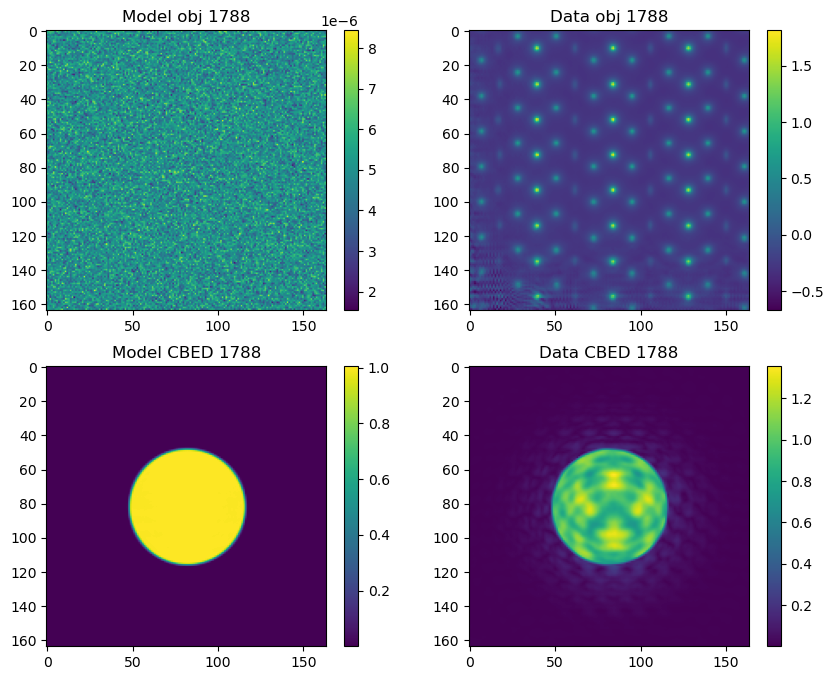

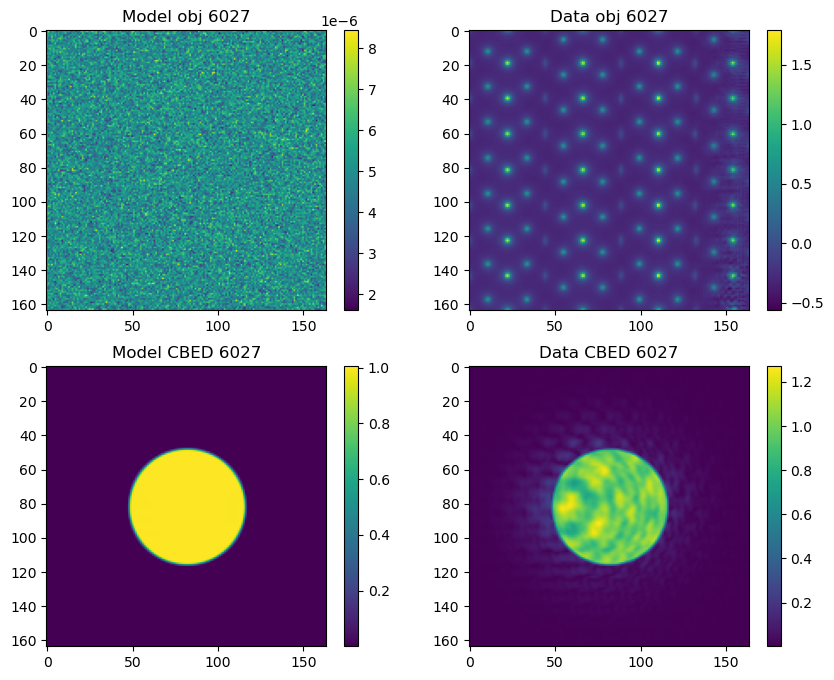

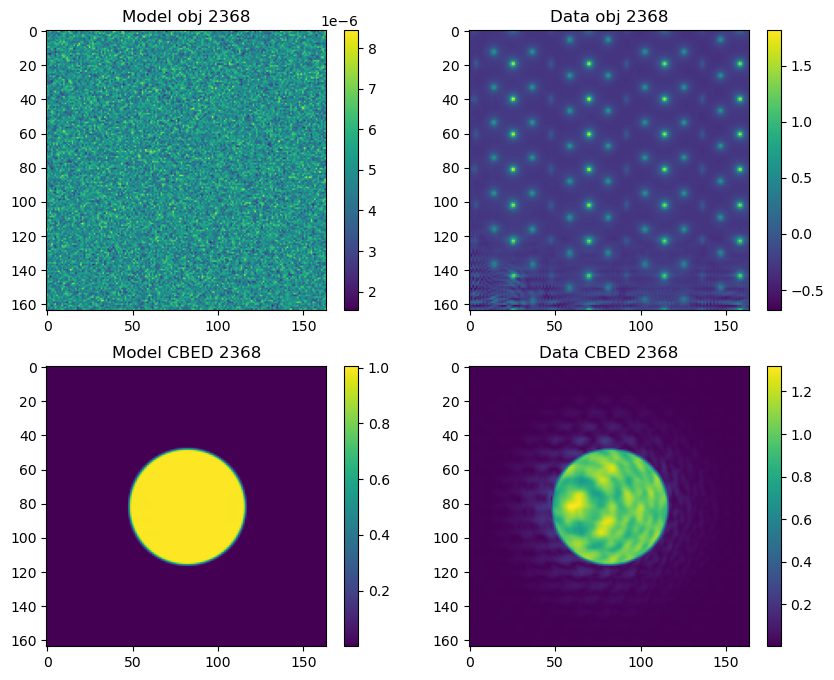

In [8]:
indices = np.random.randint(0,N_max,3)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, object_data, crop_indices_data, cbeds_data)

# 03. Main optimization loop

## Finetune the loss params

In [9]:
loss_params = {
    'loss_single': {'state':  True,  'weight': 1.0, 'dp_pow': 0.5},
    'loss_pacbed': {'state': False,  'weight': 1.0, 'dp_pow': 0.2},
    'loss_tv'    : {'state': False,  'weight': 1e-4},
    'loss_l1'    : {'state': False,  'weight': 1.0},
    'loss_l2'    : {'state': False,  'weight': 1.0},
    'loss_postiv': {'state':  True,  'weight': 1.0}
}
with torch.no_grad():
    loss_fn = CombinedLoss(loss_params, device=DEVICE)
    #np.random.seed(42)
    indices = np.random.randint(0,N_max,32)
    model_CBEDs, objp_patches = model(indices)
    measured_CBEDs = measurements[indices]
    loss_batch, losses = loss_fn(model_CBEDs, measured_CBEDs, objp_patches, model.omode_occu)

# Print loss_name and loss_value with padding
for loss_name, loss_value in zip(loss_params.keys(), losses):
    print(f"{loss_name.ljust(11)}: {loss_value.detach().cpu().numpy():.8f}")

loss_single: 0.34265319
loss_pacbed: 0.00000000
loss_tv    : 0.00000000
loss_l1    : 0.00000000
loss_l2    : 0.00000000
loss_postiv: 0.00000000


In [10]:
output_path = 'output/CNS_32obj_10slice_3e-4_random_postiv/'
os.makedirs(output_path, exist_ok=True)

NITER = 80
BATCH_SIZE = 16
num_batch = len(measurements) / BATCH_SIZE # The actual batch size would only be "close" if it's not divisible by len(measurments)
cbed_shape = measurements.shape[1:]
loss_iters = []


for iter in range(NITER+1):
    batch_losses = {name: [] for name in loss_params.keys()}
    shuffled_indices = np.random.choice(len(measurements), size=len(measurements), replace=False) # Creates a shuffled 1D array of indices
    batches = np.array_split(shuffled_indices, num_batch)                                         # return a list of `num_batch` arrays, or [batch0, batch1, ...]
    start_iter_t = time()

    for batch_idx, batch in enumerate(batches):
        start_batch_t = time()
        optimizer.zero_grad()
        model_CBEDs, objp_patches = model(batch)
        measured_CBEDs = measurements[batch]
        loss_batch, losses = loss_fn(model_CBEDs, measured_CBEDs, objp_patches, model.omode_occu)
        loss_batch.backward()
        optimizer.step()
        torch.cuda.synchronize()
        end_batch_t = time()

        for loss_name, loss_value in zip(loss_params.keys(), losses):
            batch_losses[loss_name].append(loss_value.detach().cpu().numpy())

        if batch_idx in np.linspace(0, len(batches) - 1, num=6, dtype=int):
            print(f"Done batch {batch_idx} in iter {iter} in {(end_batch_t - start_batch_t):.3f} sec")
            
    torch.cuda.synchronize()
    end_iter_t = time()

    avg_losses = {name: np.mean(values) for name, values in batch_losses.items()}
    loss_str = ', '.join([f"{name}: {value:.4f}" for name, value in avg_losses.items()])
    print(f"Iter: {iter}, Total Loss: {sum(avg_losses.values()):.4f}, {loss_str}, "
          f"in {(end_iter_t - start_iter_t) // 60} min {(end_iter_t - start_iter_t) % 60:03f} sec")

    loss_iters.append(sum(avg_losses.values()))      
    
    # # ## Saving
    if iter % 5 == 0:
        torch.save(model.state_dict(), os.path.join(output_path, f"model_CNS_32obj_10slice_3e-4_iter{str(iter).zfill(4)}.pt"))
        imwrite(os.path.join(output_path, f"image_CNS_32obj_10slice_3e-4_iter{str(iter).zfill(4)}.tif"), model.opt_objp.detach().cpu().numpy()[:,0].astype('float32'))



Done batch 0 in iter 0 in 2.006 sec
Done batch 88 in iter 0 in 1.261 sec
Done batch 177 in iter 0 in 1.259 sec
Done batch 266 in iter 0 in 1.259 sec
Done batch 355 in iter 0 in 1.261 sec
Done batch 444 in iter 0 in 1.258 sec
Iter: 0, Total Loss: 0.2400, loss_single: 0.2350, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0050, in 9.0 min 22.323184 sec
Done batch 0 in iter 1 in 1.353 sec
Done batch 88 in iter 1 in 1.257 sec
Done batch 177 in iter 1 in 1.258 sec
Done batch 266 in iter 1 in 1.256 sec
Done batch 355 in iter 1 in 1.257 sec
Done batch 444 in iter 1 in 1.261 sec
Iter: 1, Total Loss: 0.1687, loss_single: 0.1614, loss_pacbed: 0.0000, loss_tv: 0.0000, loss_l1: 0.0000, loss_l2: 0.0000, loss_postiv: 0.0073, in 9.0 min 21.563098 sec
Done batch 0 in iter 2 in 1.330 sec
Done batch 88 in iter 2 in 1.254 sec
Done batch 177 in iter 2 in 1.257 sec
Done batch 266 in iter 2 in 1.261 sec
Done batch 355 in iter 2 in 1.256 sec
Done batch 444 in iter 2 in

In [15]:
from scipy.stats import mode

In [29]:
result = mode(model.opt_objp.sum(1).detach().cpu().numpy(), 0)

In [30]:
result[0]

array([[3.18426191e-06, 3.17907916e-06, 3.00434908e-06, ...,
        2.86805266e-06, 3.35826053e-06, 3.54237773e-06],
       [3.32973013e-06, 2.66918050e-06, 3.01455430e-06, ...,
        3.26705185e-06, 3.00415013e-06, 3.35656182e-06],
       [2.57690908e-06, 3.06231937e-06, 3.27946850e-06, ...,
        3.31985416e-06, 3.75470177e-06, 3.14982367e-06],
       ...,
       [2.60214097e-06, 3.27484759e-06, 2.68672284e-06, ...,
        3.46458341e-06, 3.39408393e-06, 3.32025661e-06],
       [3.43187253e-06, 2.96888425e-06, 2.88341016e-06, ...,
        3.07443452e-06, 3.28431270e-06, 3.04160881e-06],
       [2.54729184e-06, 2.71750196e-06, 3.16987325e-06, ...,
        3.60503486e-06, 3.29364070e-06, 2.28232057e-06]])

In [33]:
imwrite(os.path.join(output_path, f"image_CNS_32obj_10slice_3e-4_iter{str(iter).zfill(4)}_zsum_omode.tif"), (mode(model.opt_objp.sum(1).detach().cpu().numpy().astype('float32'), 0)[0]).astype('float32'))

In [ ]:
# output_path = 'output\CNS_1obj_positivity'
# # #imwrite(os.path.join(output_path, f"image_CNS_1obj_3e-4_iter300_loss1.67_sqsqrt.tif"), model.opt_objp.detach().cpu().numpy()[0,0].astype('float32'))
# imwrite(os.path.join(output_path, f"image_CNS_1obj_3slice_1e-4_iter2000_nonneg.tif"), model.opt_objp.detach().cpu().numpy().astype('float32'))
# # torch.save(model.state_dict(), os.path.join(output_path, f"model_CNS_1obj_10slice_3e-4_iter100_clamp_roll5.pt"))


In [ ]:
indices = np.random.randint(0,N_max,3)
dp_power = 0.5

plot_forward_pass(model, indices, dp_power, object_data, crop_indices_data, cbeds_data)

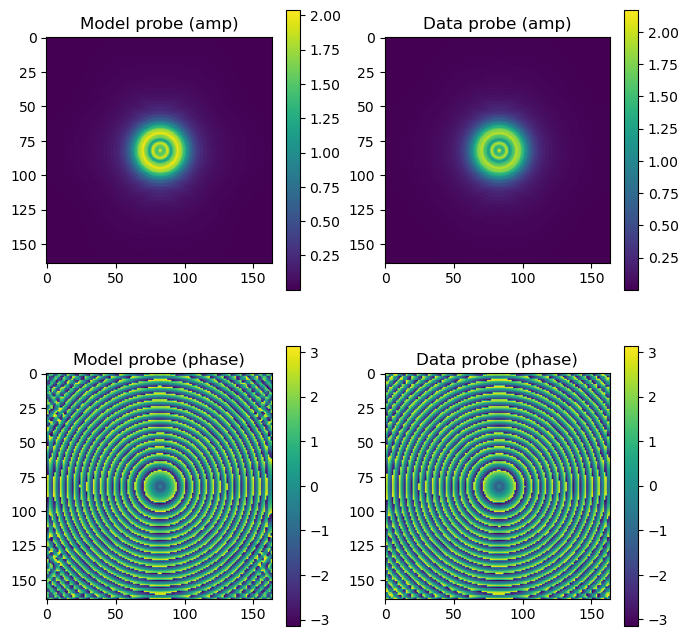

In [34]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
im00=axs[0,0].imshow(model.opt_probe[0].abs().detach().cpu())
im01=axs[0,1].imshow(np.abs(probe_data[0]))
im10=axs[1,0].imshow(model.opt_probe[0].angle().detach().cpu())
im11=axs[1,1].imshow(np.angle(probe_data[0]))

axs[0,0].set_title("Model probe (amp)")
axs[0,1].set_title("Data probe (amp)")
axs[1,0].set_title("Model probe (phase)")
axs[1,1].set_title("Data probe (phase)")


fig.colorbar(im00)
fig.colorbar(im01)
fig.colorbar(im10)
fig.colorbar(im11)

plt.show()

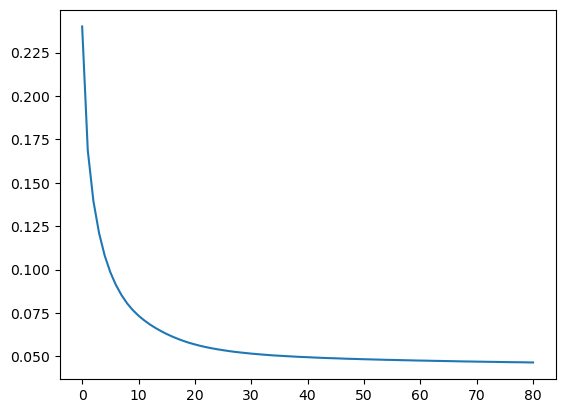

In [11]:
plt.figure()
plt.plot([x for x in loss_iters])
plt.show()